In [1]:
import os
from pathlib import Path

import chromadb
import lovely_tensors as lt
import torch
from dotenv import load_dotenv
from langchain.chat_models.openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_text_splitters import TokenTextSplitter
from PIL import Image, ImageDraw, ImageFont
from transformers import CLIPModel, CLIPProcessor
from langchain_core.prompts import ChatPromptTemplate
import ollama
from unidecode import unidecode
import html

from llavart.utils.dirutils import get_data_dir
from llavart.models.prompting import *

lt.monkey_patch()
load_dotenv()

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
IMG_DIR = Path("data") / "images"
img_paths = list(IMG_DIR.glob("*.jpg"))

In [3]:
client = chromadb.PersistentClient("store")
collection = client.get_or_create_collection(os.getenv("IMAGE_EMBEDDINGS_COLLECTION_NAME"))
graph = Neo4jGraph()

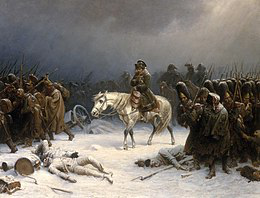

In [6]:
img = Image.open("260px-Napoleons_retreat_from_moscow.jpg")
img

In [7]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [8]:
with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt")
    outputs = model.get_image_features(**inputs).squeeze()
outputs

tensor[512] 2Kb x∈[-4.788, 2.150] μ=-0.012 σ=0.426

In [9]:
similar_ids = collection.query(
    query_embeddings=outputs.tolist(),
    n_results=3,
)["ids"][0]

In [10]:
artworks_dict = {}

In [11]:
for id in similar_ids:
    query = f"""
    MATCH(n: Artwork)
    WHERE ID(n) = {id}
    RETURN n
    """
    results = graph.query(query)
    artworks_dict[id] = results[0]["n"]

In [12]:
props_dict = {}

In [13]:
for id, artwork in artworks_dict.items():
    query = f"""
    MATCH(a: Artwork) -- (n)
    WHERE ID(a) = {id}
    RETURN n, LABELS(n) as labels
    """
    results = graph.query(query)
    props_dict[id] = results

In [14]:
artwork_contexts = []

for i, (id, artwork) in enumerate(artworks_dict.items()):
    context =f"Similar Artwork {i}\n"
    context += artwork_to_prompt(artwork)
    media = []
    tags = []
    for prop in props_dict[id]:
        if prop["labels"][0] == "Artist":
            artist = prop["n"]
            context += f"\nArtist\n{artist_to_prompt(artist)[:200]}"
        elif prop["labels"][0] == "Style":
            style = prop["n"]
            context += f"\nStyle\n{style_to_prompt(style)[:200]}"
        elif prop["labels"][0] == "Genre":
            genre = prop["n"]
            context += f"\n{genre_to_prompt(genre)}"
        elif prop["labels"][0] == "Media":
            media.append(prop["n"])
        elif prop["labels"][0] == "Tag":
            tags.append(prop["n"])
    if media:
        context += f"\n{media_to_prompt(media)}"
    if tags:
        context += f"\n{tags_to_prompt(tags)}"
    context += "\n______________________________________________________"
    artwork_contexts.append(context)

In [15]:
print("\n".join(artwork_contexts[0:3]))

Similar Artwork 0
Title: Three in the Snow
Artist
Name: Józef Chełmoński
Birth: November 7, 1849
Death: April 6, 1914
Gender: male
Style
Name: realism
Summary: Realism in the arts is generally the attempt to represent subject matter truthfully, without artificiality and avoiding speculative and supernatural elements. The term is often 
Genre: genre painting
Media: canvas, oil
______________________________________________________
Similar Artwork 1
Title: Taking a snowy town
Dimensions: 156 x 282 cm
Artist
Name: Vasily Surikov
Birth: January 24, 1848, Krasnoyarsk
Death: March 19, 1916, Russian_Empire
Gender: male
Biography:  
Style
Name: realism
Summary: Realism in the arts is generally the attempt to represent subject matter truthfully, without artificiality and avoiding speculative and supernatural elements. The term is often 
Genre: genre painting
Media: canvas, oil
Tags: games-and-sport, winter, celebrations-and-festivals, rituals-and-traditions
_____________________________________

In [16]:
context = "\n".join(artwork_contexts[0:3])
context = f"""<context>
{context}
</context>
"""
messages = [
    {"role": "system", "content": f"You are a helpful AI that can answer questions about art. You are able to make people and places recognition. Use the below context to help you answer:\n{context}"},
]

In [25]:
user_message = {"role": "user", "content": "Who is the man at the center?", "images": ["260px-Napoleons_retreat_from_moscow.jpg"]}
new_messages = messages + [user_message]

In [26]:
res = ollama.chat(
	model="llava:13b",
	messages=new_messages,
    options={
        "temperature": 1.5,
        "seed": 42
    }
)

print(res['message']['content'])

 In the image provided, it appears to be a historical painting depicting a military scene with numerous figures, likely from a past war or battle. There is a man in a central position riding a horse, which may indicate that he is a leader of some sort. However, without more specific details about this particular piece of artwork or any accompanying information such as artist or historical context, it's challenging to provide an accurate identification of the individual. If you have additional details about the artwork, I can attempt to provide more insight into who that man is supposed to be portraying.
